In [4]:
import sys
import os
import pandas as pd


import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from IPython.display import display
%matplotlib inline

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

import pickle

import gensim
import multiprocessing

from gensim.models import ldaseqmodel
from gensim import corpora, utils
from gensim.matutils import hellinger

from gensim.models import CoherenceModel

import nltk

In [2]:
# unpack data file

with open ('../data/data_list_bert', 'rb') as fp:
    itemlist = pickle.load(fp)
    
df, documents, dictionary, corpus = itemlist  

# Make a index to word dictionary.
id2word = dictionary.id2token

In [5]:
cc_tok = [nltk.word_tokenize(cc) for cc in df['bert_filtered']]
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(cc_tok)]

In [13]:
documents[0]

TaggedDocument(words=['psychiatric', 'related', 'revisit', 'follow', 'rapid', 'expansion', 'community', 'mental', 'health', 'service', 'repeat', 'visit', 'revisit', 'ed', 'psychiatric', 'reflect', 'poor', 'continuity', 'impose', 'high', 'financial', 'cost', 'test', 'rapid', 'expansion', 'community', 'health', 'center', 'provide', 'regional', 'low', 'cost', 'primary', 'correspond', 'few', 'repeat', 'psychiatric', 'related', 'visit'], tags=[0])

In [14]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

model = Doc2Vec(documents,
                vector_size=50,
                window=5,
                min_count=2,
                workers=7,
                epochs = 50
               )


In [30]:
#Create Data set for clustering and visualization

def create_embed_df(model):
    df = pd.DataFrame(model.docvecs)
    return df

df_embed = pd.DataFrame(model.docvecs.vectors_docs)

In [24]:
type(model.docvecs)

gensim.models.keyedvectors.Doc2VecKeyedVectors

In [31]:
df_embed.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.423127,-0.325255,-0.372356,-0.459697,-1.760051,-0.560866,-0.397572,-0.620207,-1.601368,-0.763240,...,-0.819184,-0.759098,1.325127,0.558562,-0.054264,-0.449703,0.586114,1.802837,-0.101993,-2.277374
1,1.358857,-2.055720,0.344745,0.438455,0.473667,0.334211,-0.386773,0.228922,-0.951322,0.704666,...,-1.200282,0.251743,1.890992,0.051328,-0.625450,1.149906,-1.540774,0.127653,0.825923,0.525348
2,0.575154,-4.638472,-0.977444,0.865572,1.170409,-0.249555,2.468536,0.021963,1.781043,-2.255162,...,-1.247886,-1.078160,-0.034777,0.713470,-0.199844,0.394905,0.073337,-0.592475,-0.203352,0.186755
3,-0.282276,-0.245924,-0.252865,1.866966,-0.170677,0.086788,0.012622,-0.266327,0.134747,-0.361289,...,0.260383,-0.477455,-0.132662,1.125503,0.278111,0.469111,0.620258,0.343618,-0.699443,-0.018972
4,0.350402,-0.460605,-0.304159,0.040607,-0.828521,0.424963,0.641906,-0.088057,-0.014667,0.308223,...,-0.359795,-0.238707,-0.067000,0.905410,0.569783,-0.260482,1.057439,0.252078,-0.390052,0.097006


In [37]:
import umap
d = 0.01
n = 10
reducer = umap.UMAP(min_dist = d, n_neighbors = n, random_state=42)

In [38]:
embedding = reducer.fit_transform(df_embed)
embedding.shape

(20528, 2)

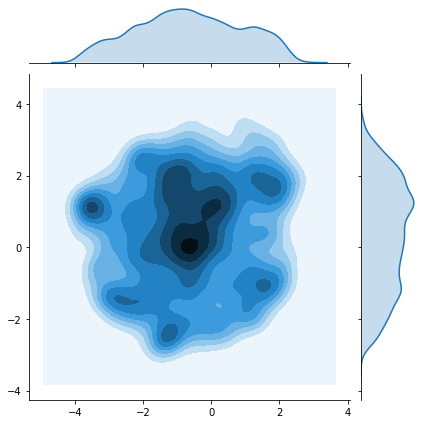

In [39]:
sns.jointplot(x=embedding[:,0], y=embedding[:,1], kind='kde', nlevels=20)

In [51]:
from sklearn import mixture
import numpy as np

def GMM(embedding,n_clust):
    gmm = mixture.GaussianMixture(n_components=n_clust, random_state=42, covariance_type="full")
    gmm.fit(embedding)
    return gmm.predict(embedding), gmm
    
    
def plot_GMM(embedding, y):
    f, ax = plt.subplots(figsize=(8, 8))
    plt.scatter(embedding[:, 0], embedding[:, 1], s= .01, c=y, cmap='Spectral')
    plt.colorbar()

def cluster_center_calc(embedding, gmm_model): 
    cent = []
    gmm_clusters = gmm_model.predict(embedding)
    for c in np.unique(gmm_clusters):
        cent.append(np.median(embedding[gmm_clusters == c,:], axis = 0))
    return cent    
    
def cluster_center(embedding,gmm_model):
    centers = []
    gmm_clusters = gmm_model.predict(embedding)
    for c in np.unique(gmm_clusters):
        centers.append(np.mean(embedding[gmm_clusters == c,:], axis = 0))
    return centers

def plot_GMM_centers(embedding, y, centers):
    f, ax = plt.subplots(figsize=(8, 8))
    plt.scatter(embedding[:, 0], embedding[:, 1], s= .01, c=y, cmap='Spectral')
    plt.axis('off')
    i = 0
    for c in centers:
        plt.text(c[0], c[1], i, fontsize=16)
        i = i+1


In [53]:
n_clust = 50
gmm_clusters, gmm_model = GMM(embedding,n_clust)
centers = cluster_center_calc(embedding, gmm_model)
threshold_clust = np.where(np.bincount(gmm_clusters) > 200)[0]

In [54]:
threshold_clust

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]


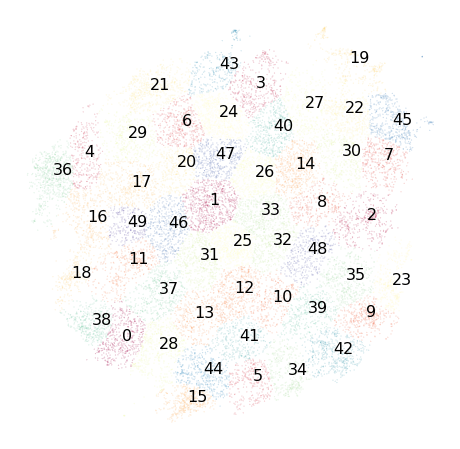

In [55]:
plot_GMM_centers(embedding,gmm_clusters,centers)
print(threshold_clust)